# WeatherShow

### import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from statistics import mean, median,variance,stdev
from tqdm import tqdm_notebook as tqdm

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## RDP

(2, 1000)
(2, 9)


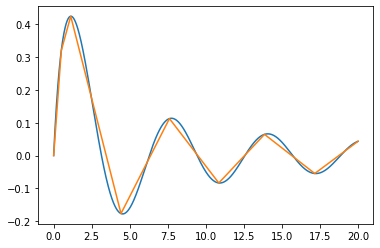

1000
2


In [2]:



def rdp(allPoints, epsilon):
    allPoints = allPoints.transpose()
    #print(epsilon)
    startID = 0
    endID = len(allPoints)-1
    #print(startID)
    #print(endID)
    rdpPoints = []
    rdpPoints.append(allPoints[startID])
    rdpPoints = rdpIn(startID, endID, allPoints, rdpPoints, epsilon)
    rdpPoints.append(allPoints[endID])
    return np.array(rdpPoints).transpose()

def rdpIn(startID, endID, allPoints, rdpPoints, epsilon):
    nextID = findFurthest(allPoints, startID, endID, epsilon)
    if nextID > 0:
        if startID != nextID:
            rdpIn(startID, nextID, allPoints, rdpPoints, epsilon)
        rdpPoints.append(allPoints[nextID])
        if endID != nextID:
            rdpIn(nextID, endID, allPoints, rdpPoints, epsilon)
    return rdpPoints

def findFurthest(points, a, b, epsilon):
    maxDist = 0
    findID = -1;
    for i in range(a+1,b):
        tempDist = lineDist(points[i], points[a], points[b])
        if tempDist > maxDist:
            maxDist = tempDist
            findID = i
    #print(epsilon)
    #print(a)
    #print(findID)
    #print(maxDist)
    if maxDist > epsilon:
        return findID
    else:
        return -1

def lineDist(c, a, b):
    return np.linalg.norm(c - scalarProjection(c, a, b))

def scalarProjection(p, a, b):
    ap = p-a
    ab = b-a
    ab = normalize(ab)
    return a+ab*ap.dot(ab)

def normalize(v, axis=-1, order=2):
    l2 = np.linalg.norm(v, ord = order, axis=axis, keepdims=True)
    l2[l2==0] = 1
    return v/l2

dataLen = 1000
pos = np.zeros((2, dataLen))
pos[0, :] = np.linspace(0, 20, dataLen)
pos[1, :] = np.sin(pos[0,:])/(1+pos[0,:])
print(pos.shape)
rdped = np.array(rdp(pos, 0.1))
print(rdped.shape)
plt.plot(pos[0,:], pos[1,:])
plt.plot(rdped[0,:], rdped[1,:])
plt.show()
print(dataLen)
print(len(rdped))

### getData

In [3]:
from socket import *
import socket
import time
PORT = 5000
BUFFER_SIZE = 1024

with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.connect(('nekodigi.local', PORT))
    s.settimeout(1)
    #data = input('Please input > ')
    s.send('request'.encode())
    msg = ''
    startTime = time.time()
    for i in range(1000):
        try:
            data = s.recv(BUFFER_SIZE).decode('utf-8')
            msg = msg + data
            #print(len(data))
        except timeout:
            break
with open('WeatherData.txt', mode='w') as f:
    f.write(msg)

print('complete!')

complete!


### showData


(2, 50)


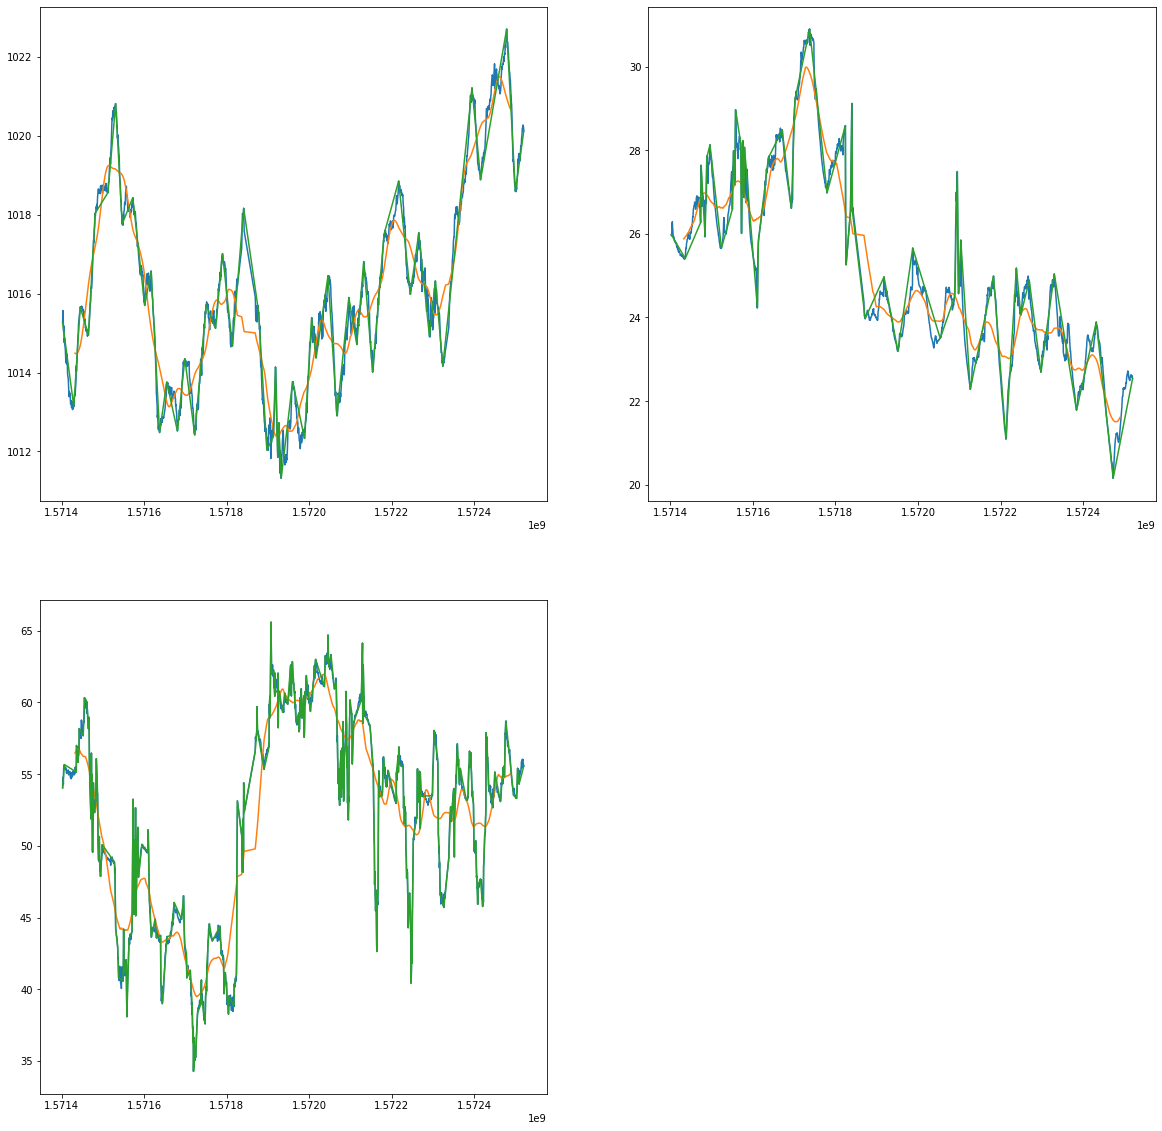

In [4]:
makeNomal = True
#Thinning------------------
Thinning=10
#Smooth----------------------
makeSmooth = True
smoothSample = 100;
sampleInterval = 1;
#Rdp---------------------------
makeRdp = True
pres_epsilon = 1
temp_epsilon = 1
hum_epsilon = 1

readDatas = None
with open('WeatherData.txt') as f:
    readDatas = f.read().split('\n')

timeAxis = []
presAxis = []
tempAxis = []
humAxis = []
s_timeAxis = None
s_presAxis = None
s_tempAxis = None
s_humAxis = None
totalData = 0
readCount = 0
for readData in tqdm(readDatas):
    if readData != '' and readCount % Thinning == 0:
        datas = readData.split(',')
        dte = datetime.datetime.strptime(datas[3], '%Y:%m:%d:%H:%M')
        if float(datas[0].strip("\x00")) >= 800:
            timeAxis.append(int(datas[4]))
            presAxis.append(float(datas[0].strip("\x00")))
            tempAxis.append(float(datas[1]))
            humAxis.append(float(datas[2]))
            totalData+=1
    readCount+=1

if makeSmooth:
    s_timeAxis = np.array([])
    s_presAxis = np.array([])
    s_tempAxis = np.array([])
    s_humAxis = np.array([])
    for i in tqdm(range(0, len(timeAxis)-smoothSample, sampleInterval)):
        s_timeAxis = np.append(s_timeAxis, timeAxis[int(i+smoothSample/2)])
        s_presAxis = np.append(s_presAxis, mean(presAxis[i:i+smoothSample:sampleInterval]))
        s_tempAxis = np.append(s_tempAxis, mean(tempAxis[i:i+smoothSample:sampleInterval]))
        s_humAxis = np.append(s_humAxis, mean(humAxis[i:i+smoothSample:sampleInterval]))
if makeRdp:
    rdped_presAxis = rdp(np.stack([timeAxis, presAxis]), pres_epsilon)
    rdped_tempAxis = rdp(np.stack([timeAxis, tempAxis]), temp_epsilon)
    rdped_humAxis = rdp(np.stack([timeAxis, humAxis]), hum_epsilon)
#print(np.stack([timeAxis, presAxis]))
print(rdped_presAxis.shape)
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
if makeNomal:
    ax1.plot(timeAxis, presAxis)
    ax2.plot(timeAxis, tempAxis)
    ax3.plot(timeAxis, humAxis)
if makeSmooth:
    ax1.plot(s_timeAxis, s_presAxis)
    ax2.plot(s_timeAxis, s_tempAxis)
    ax3.plot(s_timeAxis, s_humAxis)
if makeRdp:
    ax1.plot(rdped_presAxis[0], rdped_presAxis[1])
    ax2.plot(rdped_tempAxis[0], rdped_tempAxis[1])
    ax3.plot(rdped_humAxis[0], rdped_humAxis[1])
plt.show()

In [5]:
def make_dataset(in_data, maxlen=25, step=1):
    data, target = [], []
    for i in range(len(in_data)-maxlen):
        data.append(in_data[i:i+maxlen:step])
        target.append(in_data[i+maxlen])
    re_data = np.array(data).reshape(len(data), int(maxlen/step), 1)
    re_target = np.array(target).reshape(len(data), 1)
    
    return re_data, re_target

x_train, y_train = make_dataset(s_tempAxis/50)#------------
#x_train, y_train = make_dataset(f)
print(x_train.shape)

(1661, 25, 1)


In [ ]:
length_of_sequence = x_train.shape[1]
in_out_neurons = 1
n_hidden = 300
print(length_of_sequence)

model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, in_out_neurons), return_sequences=False))
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))
optimizer = Adam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer)

In [2]:
#early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
model.fit(x_train, y_train,
         batch_size=300,
         epochs=10,
         validation_split=0.1#,
         #callbacks=[early_stopping]
         )

NameError: name 'model' is not defined

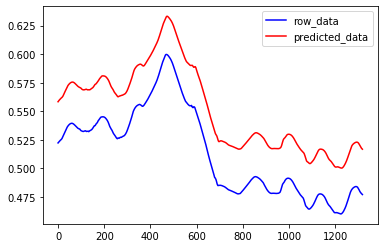

In [131]:
model.load_weights('100epochTest.hdf5')
predicted = model.predict(x_train)
plt.figure()
plt.plot(range(0, len(y_train)), y_train, color="b", label="row_data")
plt.plot(range(0, len(predicted)), predicted, color="r", label="predicted_data")
plt.legend()
plt.show()

(1, 25)


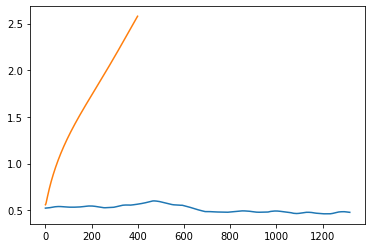

In [132]:
off=0
future_test = x_train[off].T
print(future_test.shape)
time_length = x_train.shape[1]
future_result = np.empty((0))
for step in range(400):
    test_data = np.reshape(future_test, (1, time_length, 1))
    batch_predict = model.predict(test_data)
    
    future_test = np.delete(future_test, 0)
    future_test = np.append(future_test, batch_predict)
    
    future_result = np.append(future_result, batch_predict)
    
plt.figure()
plt.plot(range(0, len(y_train)+0),y_train)
plt.plot(range(off, len(future_result)+off), future_result)